In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '20px'
      rule.style.color = 'black'
      break
    }
  }
  '''))
increase_font()
get_ipython().events.register('pre_run_cell', increase_font)
print("Hello in ")
print("...in larger font ")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hello in 
...in larger font 


#HATE SPEECH DETECTION CHATBOT

###Data Preparation


1.   Importing / Uploading Data & Required Files
2.   EDA ( Exploratory Data Analysis)
3.   Data Pre-processing
     *  Text Processing
     
     *  Lemmatization

4.   Visulation:
     * Count Plot
     * Word Clouds







In [ ]:
import nltk
nltk.download('stopwords')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
## Importing the required files
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# uploading dataset 
from google.colab import files
uploaded = files.upload()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving labeled_data.csv to labeled_data (1).csv


In [ ]:
# importing dataset as tweet_df
import io
tweet_df = pd.read_csv(io.BytesIO(uploaded['labeled_data.csv']))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Exploratory Data

In [ ]:
# Viewing 5 rows from the top
tweet_df.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# Renaming 'class' column to 'label'
tweet_df.rename(columns = {'class':'label'}, inplace = True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# dimensionality of dataset
tweet_df.shape

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(24783, 7)

In [ ]:
# Frequency of each label
tweet_df['label'].value_counts()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1    19190
2     4163
0     1430
Name: label, dtype: int64

In [ ]:
# Checking for null values
tweet_df.isna().sum().sum()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0

In [ ]:
# Checking for duplicate values
tweet_df[tweet_df.duplicated()]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Unnamed: 0,count,hate_speech,offensive_language,neither,label,tweet


In [ ]:
# summary of dataset
tweet_df.info()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   label               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


#Pre-processing Data


In [ ]:
# Extracting columns 'label' and 'tweet'
tweet_df = tweet_df[['label','tweet']]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# printing random tweets 
print(tweet_df['tweet'].iloc[0],"\n")
print(tweet_df['tweet'].iloc[1],"\n")
print(tweet_df['tweet'].iloc[2],"\n")
print(tweet_df['tweet'].iloc[3],"\n")
print(tweet_df['tweet'].iloc[4],"\n")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out... 

!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!! 

!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit 

!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny 

!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361; 



###The purpose of the function is to perform various text processing tasks on the input tweet and return a cleaned version of the tweet.

In [ ]:
#creating a function to process the data
def data_processing(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"https\S+|www\S+http\S+", '', tweet, flags = re.MULTILINE)
    tweet = re.sub(r'\@w+|\#','', tweet)
    tweet = re.sub(r'[^\w\s]','',tweet)
    tweet = re.sub(r'ð','',tweet)
    tweet_tokens = word_tokenize(tweet) #tokenizes the tweet text into individual words 
    filtered_tweets = [w for w in tweet_tokens if not w in stop_words] # removes any stop words (commonly occurring words like "the", "and", etc.) 
    return " ".join(filtered_tweets) # combines remaining words together into a single string

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import nltk
nltk.download('punkt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# apply data_processing function to each tweet
tweet_df.tweet = tweet_df['tweet'].apply(data_processing)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
tweet_df.info()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [ ]:
# checking for duplicate values
tweet_df[tweet_df.duplicated()]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,label,tweet
5570,1,b_shiznitt fuck bitch
6587,1,lkxox_ bitch
7538,1,aint bitch
7890,1,baby make pussy rain often
7913,1,bad bitches good weed
...,...,...
24473,1,stupid bitch
24480,1,sup bitches
24563,1,bitch
24660,1,hoe


In [ ]:
# remove duplicate values
tweet_df = tweet_df.drop_duplicates('tweet')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
tweet_df.info()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24698 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   24698 non-null  int64 
 1   tweet   24698 non-null  object
dtypes: int64(1), object(1)
memory usage: 578.9+ KB


###As we can see above, the number of rows has reduced from 24783 to 24698 because of the removal of duplicate tweets

### The function uses the Natural Language Toolkit's WordNetLemmatizer to lemmatize each word in the input data. Lemmatization is a process of converting a word to its base or root form.

###The function creates a list of lemmatized words by applying the "lemmatize" method of the WordNetLemmatizer to each word in the input data. The list of lemmatized words is assigned to a variable named "tweet".

In [ ]:
#Lemmatization
lemmarizer = WordNetLemmatizer()
def lemmatizing(data):
    tweet = [lemmarizer.lemmatize(word) for word in data]
    return data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import nltk
nltk.download('wordnet')

import nltk
nltk.download('omw-1.4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# apply lemmatizing function to each tweet
tweet_df['tweet'] = tweet_df['tweet'].apply(lambda x: lemmatizing(x))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# printing the data to see the effect of preprocessing
print(tweet_df['tweet'].iloc[0],"\n")
print(tweet_df['tweet'].iloc[1],"\n")
print(tweet_df['tweet'].iloc[2],"\n")
print(tweet_df['tweet'].iloc[3],"\n")
print(tweet_df['tweet'].iloc[4],"\n")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

rt mayasolovely woman shouldnt complain cleaning house amp man always take trash 

rt mleew17 boy dats coldtyga dwn bad cuffin dat hoe 1st place 

rt urkindofbrand dawg rt 80sbaby4life ever fuck bitch start cry confused shit 

rt c_g_anderson viva_based look like tranny 

rt shenikaroberts shit hear might true might faker bitch told ya 57361 



In [ ]:
tweet_df.info()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24698 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   24698 non-null  int64 
 1   tweet   24698 non-null  object
dtypes: int64(1), object(1)
memory usage: 578.9+ KB


In [ ]:
tweet_df['label'].value_counts()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1    19111
2     4160
0     1427
Name: label, dtype: int64

In [ ]:
tweet_df.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,label,tweet
0,2,rt mayasolovely woman shouldnt complain cleani...
1,1,rt mleew17 boy dats coldtyga dwn bad cuffin da...
2,1,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,1,rt c_g_anderson viva_based look like tranny
4,1,rt shenikaroberts shit hear might true might f...


#Data Visualization



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='label', ylabel='count'>

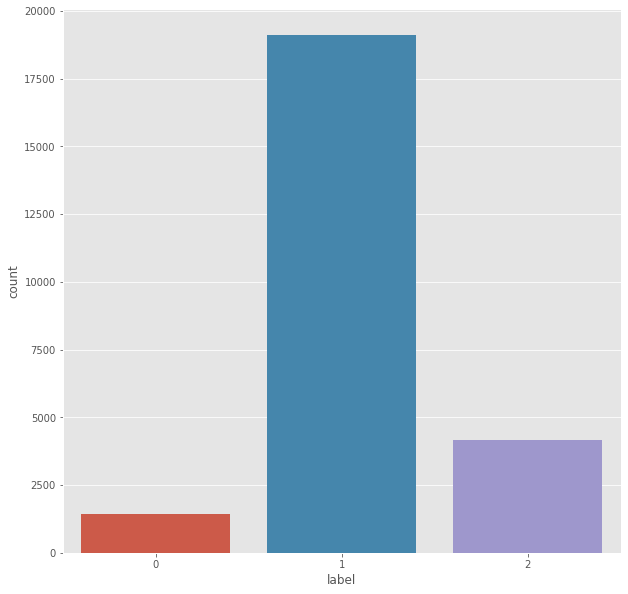

In [ ]:
# Count Plot
fig = plt.figure(figsize=(10,10))
sns.countplot(x='label', data = tweet_df)

##Word Clouds

###Word Clouds are visual representations of words that give greater prominence to words that appear more frequently.

In [ ]:
# hate_tweets has all the rows which is labelled as 0
hate_tweets = tweet_df[tweet_df.label == 0]
hate_tweets.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,label,tweet
85,0,blackman38tide halelookyhere howdydowdy11 quee...
89,0,cb_baby24 hite_thunduh alsarabsss hes beaner s...
110,0,devilgrimz vigxrarts youre fucking gay blackli...
184,0,markroundtreejr lmfaoooo hate black people the...
202,0,nochillpaz least im nigger httptcorgja7cfoit l...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

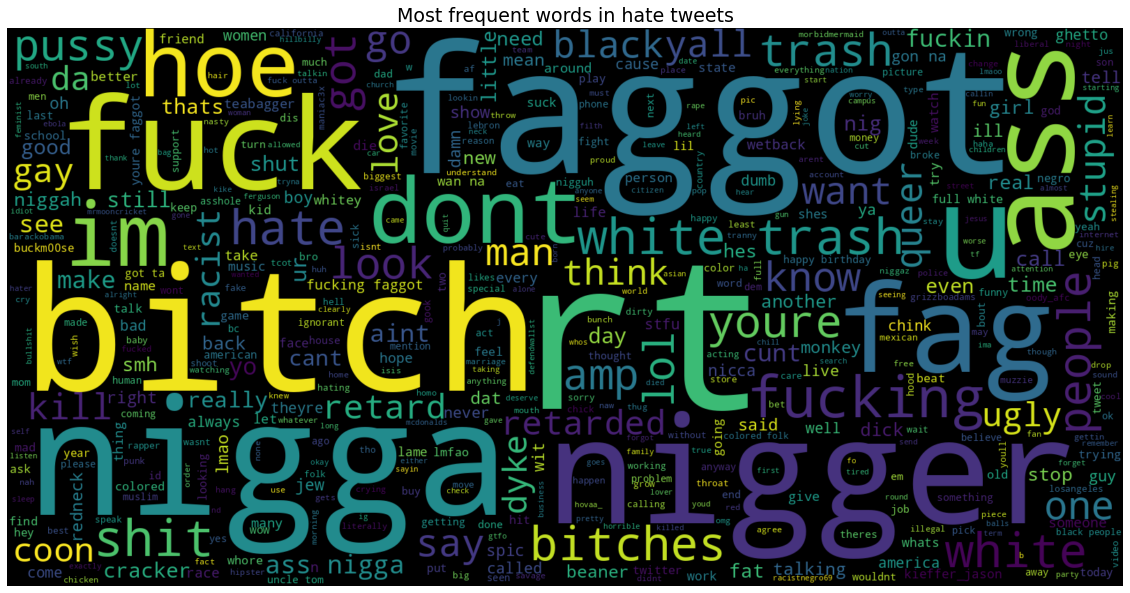

In [ ]:
text = ' '.join([word for word in hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in hate tweets', fontsize = 19)
plt.show()

In [ ]:
# off_tweets has all the rows which is labelled as 1
off_tweets = tweet_df[tweet_df.label == 1]
off_tweets.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,label,tweet
1,1,rt mleew17 boy dats coldtyga dwn bad cuffin da...
2,1,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,1,rt c_g_anderson viva_based look like tranny
4,1,rt shenikaroberts shit hear might true might f...
5,1,t_madison_x shit blows meclaim faithful somebo...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

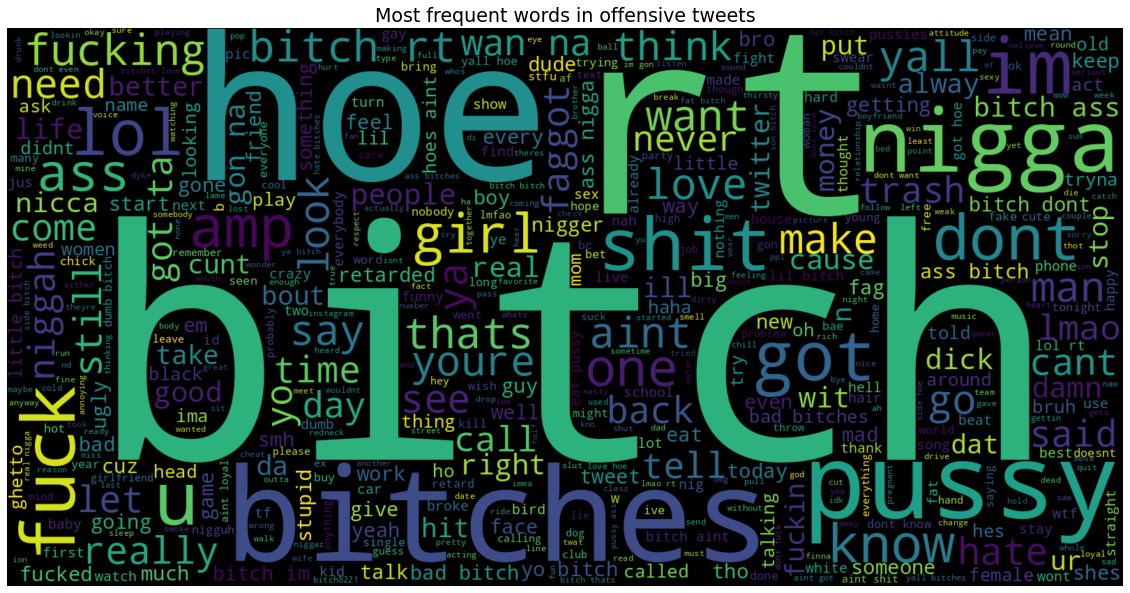

In [ ]:
text = ' '.join([word for word in off_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in offensive tweets', fontsize = 19)
plt.show()

In [ ]:
# non_hate_tweets has all the rows which is labelled as 2
non_hate_tweets = tweet_df[tweet_df.label == 2]
non_hate_tweets.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,label,tweet
0,2,rt mayasolovely woman shouldnt complain cleani...
40,2,momma said pussy cats inside doghouse
63,2,addicted2guys simplyaddictedtoguys httptco1jl4...
66,2,allaboutmanfeet httptco3gzupfumev woof woof ho...
67,2,allyhaaaaa lemmie eat oreo amp dishes one oreo...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

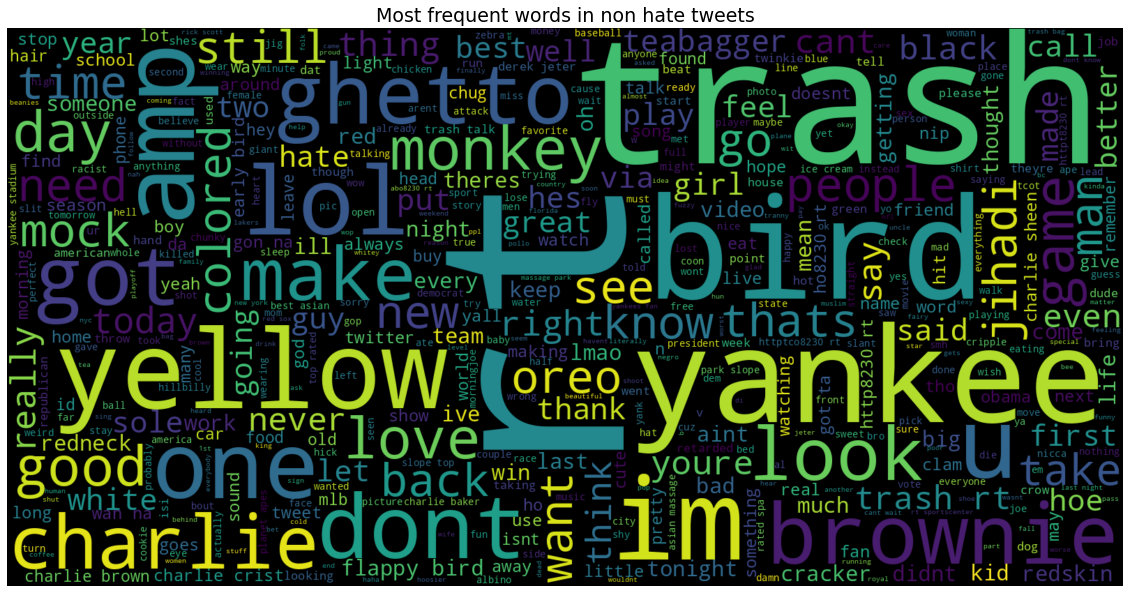

In [ ]:
text = ' '.join([word for word in non_hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in non hate tweets', fontsize = 19)
plt.show()



*   TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. 
*   This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction




The ngram_range argument specifies the range of n-grams to consider when generating features, where an n-gram is a contiguous sequence of n items from a given sample of text (in this case, words). So in this example, the TfidfVectorizer will generate features based on both individual words and pairs of words (i.e., bigrams) found in the tweets.

In [ ]:
vect = TfidfVectorizer(ngram_range=(1,2)).fit(tweet_df['tweet'])

The .fit() method is then used to fit the vectorizer to the dataset of tweets, which essentially generates the set of features based on the text in the tweets.

After fitting the vectorizer, the .get_feature_names_out() method is used to get a list of the feature names generated by the vectorizer, and this list is assigned to the variable feature_names.

Finally, the code prints out the number of features generated (which is simply the length of the feature_names list) and the first 20 features in the list.

In [ ]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[:20]))

In [ ]:
vect = TfidfVectorizer(ngram_range=(1,3)).fit(tweet_df['tweet'])

In [ ]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[:20]))